In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import string
import re
from plotly import graph_objs as go
from collections import Counter
import nltk
from nltk.corpus import stopwords

In [69]:
# output the info of the dataset



df_anger = pd.read_csv("anger-ratings-0to1.train.txt", sep='\t')
df_fear = pd.read_csv("fear-ratings-0to1.train.txt", sep='\t')
df_joy = pd.read_csv("joy-ratings-0to1.train.txt", sep='\t')
df_sadness = pd.read_csv("sadness-ratings-0to1.train.txt", sep='\t')
frames = [df_anger, df_fear, df_joy, df_sadness]
df = pd.concat(frames)

In [70]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3613 entries, 0 to 785
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         3613 non-null   int64  
 1   tweet      3613 non-null   object 
 2   tweettype  3613 non-null   object 
 3   score      3613 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 141.1+ KB


,id,tweet,tweettype,score
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [71]:
# Distribution of Sentiments
temp = df.groupby('tweettype').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

,tweettype,tweet
1,fear,1147
0,anger,857
2,joy,823
3,sadness,786


<AxesSubplot:xlabel='tweettype', ylabel='count'>

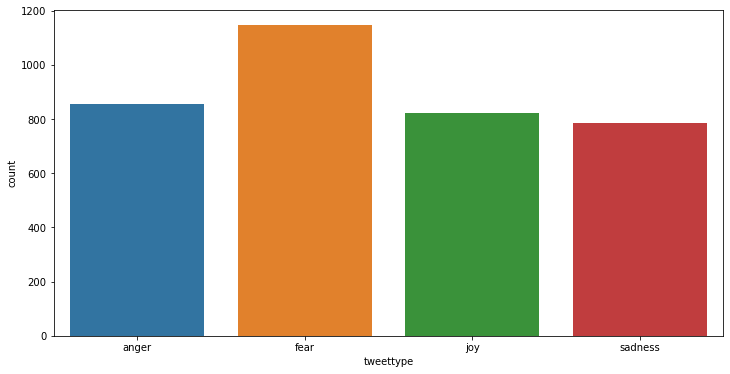

In [72]:
# Plot the distribution of sentiments
plt.figure(figsize=(12,6))
sns.countplot(x='tweettype',data=df)

In [73]:
# Use funnel char for better visualization
fig = go.Figure(go.Funnelarea(
    text =temp.tweettype,
    values = temp.tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.update_layout(
    autosize=False,
    width=1600,
    height=1600,)
fig.show()

In [74]:
# Cleaning the corpus
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['tweet'] = df['tweet'].apply(lambda x:clean_text(x))
df.head()

,id,tweet,tweettype,score
0,10000,how the fuk who the heck moved my fridge shoul...,anger,0.938
1,10001,so my indian uber driver just called someone t...,anger,0.896
2,10002,dpduk i asked for my parcel to be delivered to...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,dont join btcare they put the phone down on yo...,anger,0.896


In [75]:
# Remove stop words
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english') and y != 'im']

# Most Common Words in corpus
df['temp_list'] = df['tweet'].apply(lambda x:str(x).split())
df['temp_list'] = df['temp_list'].apply(lambda x:remove_stopword(x))
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,like,238
1,dont,204
2,get,174
3,amp,162
4,one,136
5,people,117
6,time,114
7,day,113
8,know,112
9,good,110


In [76]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [77]:
fear_sent = df[df['tweettype']=='fear']
anger_sent = df[df['tweettype']=='anger']
joy_sent = df[df['tweettype']=='joy']
sadness_sent = df[df['tweettype']=='sadness']

In [78]:
#Most common words
def count_common_words(df, color = 'Greens'):  
    top = Counter([item for sublist in df['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words','count']
    temp
    return temp

def visualize_common_words(df, title):
    fig = px.bar(df, x="count", y="Common_words", title=title, orientation='h', 
                 width=700, height=700,color='Common_words')
    fig.show()
    ig = px.treemap(df, path=['Common_words'], values='count',title=title)
    ig.show()

In [79]:
fear_count = count_common_words(fear_sent)
visualize_common_words(fear_count, "Most common fear words")

In [80]:
anger_count = count_common_words(anger_sent)
visualize_common_words(anger_count, "Most common anger words")

In [81]:
joy_count = count_common_words(joy_sent)
visualize_common_words(joy_count, "Most common joy words")

In [82]:
sadness_count = count_common_words(sadness_sent)
visualize_common_words(sadness_count, "Most common sadness words")

In [83]:
raw_text = [word for word_list in df['temp_list'] for word in word_list]
def words_unique(sentiment,numwords,raw_words):
    allother = []
    for item in df[df.tweettype != sentiment]['temp_list']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in df[df.tweettype == sentiment]['temp_list']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

In [84]:
unique_fear= words_unique('fear', 20, raw_text)
print("The top 20 unique words in Fear Tweets are:")
unique_fear.style.background_gradient(cmap='Greens')

The top 20 unique words in Fear Tweets are:


,words,count
0,terrorism,51
1,nightmare,43
2,shake,21
3,horrific,15
4,concern,14
5,terrific,12
6,dread,11
7,hesitate,9
8,frightened,7
9,terrorist,7


In [85]:
unique_sadness= words_unique('sadness', 20, raw_text)
print("The top 20 unique words in Sadness Tweets are:")
unique_sadness.style.background_gradient(cmap='Blues')

The top 20 unique words in Sadness Tweets are:


,words,count
0,blues,31
1,sober,31
2,depressing,24
3,pine,19
4,gloomy,17
5,sunk,16
6,dull,16
7,mourn,15
8,gloom,13
9,depress,10


In [86]:
unique_anger= words_unique('anger', 20, raw_text)
print("The top 20 unique words in Anger Tweets are:")
unique_anger.style.background_gradient(cmap='Reds')

The top 20 unique words in Anger Tweets are:


,words,count
0,revenge,34
1,fuming,30
2,snap,25
3,outrage,21
4,boiling,18
5,raging,18
6,sting,18
7,fury,18
8,offense,17
9,relentless,17


In [87]:
unique_joy= words_unique('joy', 20, raw_text)
print("The top 20 unique words in Fear Tweets are:")
unique_joy.style.background_gradient(cmap='Oranges')

The top 20 unique words in Fear Tweets are:


,words,count
0,lively,98
1,broadcast,54
2,optimism,40
3,glee,34
4,elated,21
5,cheering,21
6,cheer,20
7,playful,19
8,cheerful,18
9,pleasing,18
